<a href="https://colab.research.google.com/github/patjiang/ConvolutionalSelfAttention/blob/main/MNIST_CSA_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Clone Repo, run test
!git clone https://github.com/patjiang/ConvolutionalSelfAttention.git > /dev/null 2>&1
!python ConvolutionalSelfAttention/tests.py

from IPython.display import HTML
from base64 import b64encode
import os
from glob import glob

conv3d CSA passed
conv2d CSA passed
SA test passed
all tests passed


In [2]:
#@title import MNIST dataset
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('/content/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = datasets.MNIST('/content/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.11MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.10MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.92MB/s]


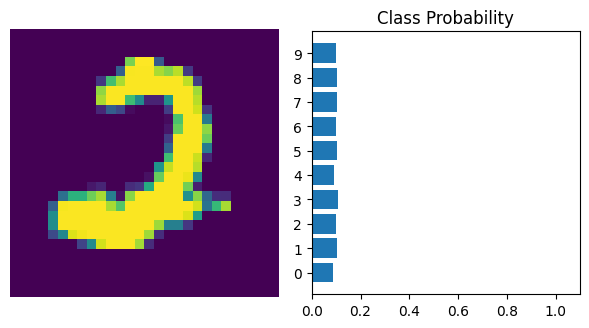

In [3]:
#@title do initial tests for data
import torch
import torch.nn as nn
import torch.nn.functional as F
from ConvolutionalSelfAttention.utils.modules import *
from ConvolutionalSelfAttention.utils.benchmark_models import *
from ConvolutionalSelfAttention.utils.benchmark_pipe import *
from ConvolutionalSelfAttention.utils.data_load_test import *

model = MNIST_CSA_1_layer(1, (28*28))

# Grab some data
dataiter = iter(trainloader)
images, labels = next(dataiter)
images.resize_(64, 1, 1, 28, 28)
img_idx = 0
pred, embed = model.forward(images[img_idx,:])
ps = F.log_softmax(pred, dim=1)
img = images[img_idx]

view_classify(img.view(1, 28, 28), torch.exp(ps))

In [4]:
#@title define toy models

class CSA_VAE(nn.Module):
  def __init__(self, in_ch, dimprod):
    super().__init__()
    self.downsamp_1 = nn.MaxPool2d(2)
    self.CSA_1 = ConvolutionalSelfAttention2d(in_ch, dimprod // 4, 2)
    self.out = nn.LazyLinear(10)
    self.mu = nn.Linear(dimprod // 4, dimprod // 4)
    self.var = nn.Linear(dimprod // 4, dimprod // 4)
    self.upsamp = nn.Upsample(scale_factor = 2)
    self.CSA_2 = ConvolutionalSelfAttention2d(in_ch, dimprod, 2)

  def reparam(self, mu, log_var):
    eps = Variable(torch.FloatTensor(log_var.size()).normal_())
    std = log_var.mul(0.5).exp_()
    return eps.to(mu.device).mul(std.to(mu.device)).add_(mu)

  def forward(self, x):
    x = self.downsamp_1(x)
    x = self.CSA_1(x)
    tmp = x.shape
    x = x.flatten(start_dim=1)
    mu, var = self.mu(x), self.var(x)
    z = self.reparam(mu, var)
    pred = self.out(z)
    z = self.upsamp(z.reshape(tmp))
    out = self.CSA_2(z)
    return pred, z, out, (mu, var)

class CSA_AE(nn.Module):
  def __init__(self, in_ch, dimprod):
    super().__init__()
    self.downsamp_1 = nn.MaxPool2d(2)
    self.CSA_1 = ConvolutionalSelfAttention2d(in_ch, dimprod // 4, 1)
    self.out = nn.LazyLinear(10)
    self.upsamp = nn.Upsample(scale_factor = 2)
    self.CSA_2 = ConvolutionalSelfAttention2d(in_ch, dimprod, 1)

  def forward(self, x):
    x = self.downsamp_1(x)
    x = self.CSA_1(x)
    tmp = x.shape
    z = x.flatten(start_dim=1)
    pred = self.out(z)
    z = self.upsamp(z.reshape(tmp))
    out = self.CSA_2(z)
    return pred, z, out

class VAE(nn.Module):
    #Taken from https://www.usna.edu/Users/cs/SD312/notes/18VAE/mnist.html
    #Changes are: Added Classification linear layer; changed hard-coded 'cuda' ops
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )

        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
        self.out = nn.LazyLinear(10)
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(mean.device)
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        pred = self.out(z)
        x_hat = self.decode(z)
        return pred, z, x_hat, (mean, logvar)

100%|██████████| 100/100 [39:53<00:00, 23.93s/it]


 best Loss:  17113.437704057837


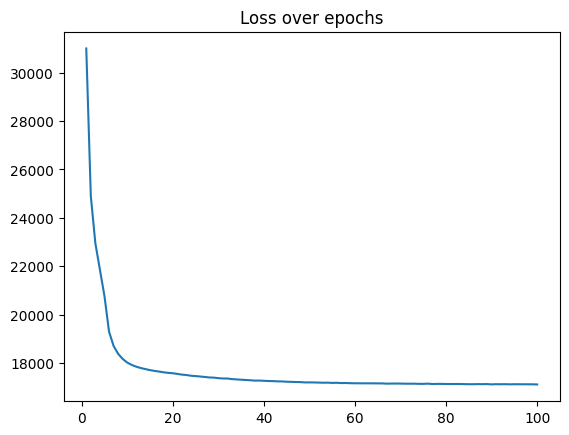

In [5]:
#@title train a one layer CSA_VAE model
model = CSA_VAE(1, (28*28)).to('cuda')
np.random.seed(42)
torch.manual_seed(42)
#for reproducibility
folder = 'lats'
nlr = 0.0002
os.makedirs(folder, exist_ok=True)
criterion1 = nn.NLLLoss()
criterion2 = nn.MSELoss(reduction = 'sum')
optimizer = optim.Adam(model.parameters(), lr=nlr)
plot_latents = False
epochs = 100
lats, labs, losses = [], [], []
for e in tqdm(range(epochs)):
    running_loss = 0
    if(e % 1 == 0):
      plot_latents = True
      lats, labs = [], []
    for images, labels in (trainloader):
        optimizer.zero_grad()
        pred, emb, recon, logits = model(images.to('cuda'))
        output = F.log_softmax(pred, dim=1)
        nlloss = criterion1(output, labels.to('cuda'))
        mseloss = criterion2(recon, images.to('cuda'))
        KLD = - 0.5 * torch.sum(1+ logits[1] - logits[0].pow(2) - logits[1].exp())
        loss = nlloss + mseloss + KLD
        loss.backward()
        optimizer.step()
        if(plot_latents):
          lats.append(emb.detach().cpu().squeeze().flatten(start_dim=1).numpy())
          labs.append(labels)
        running_loss += loss.item()
    losses.append(running_loss/len(trainloader))

    if(plot_latents):
      do_pca(lats, labs, folder, e)
      plot_latents = False
    #print(losses[-1])
print('\n best Loss: ', min(losses))
plt.plot(np.arange(1, epochs + 1), losses)
plt.title(f'Loss over epochs')
plt.show()
plt.close()
image_folder = f'/content/{folder}'

output_path = f'/content/{folder}/vid_out.mp4'

!ffmpeg -r 10 -i "{image_folder}/frame_%03d.png" -vcodec libx264 -pix_fmt yuv420p "{output_path}" > /dev/null 2>&1

video_path = f'/content/{folder}/vid_out.mp4'

mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
torch.save(model.state_dict(), 'csa_1.pt')
HTML(f"""
<video width=640 controls>
    <source src="{data_url}" type="video/mp4">
</video>
""")

100%|██████████| 100/100 [1:45:27<00:00, 63.28s/it]


 best Loss:  2404.8485152970497


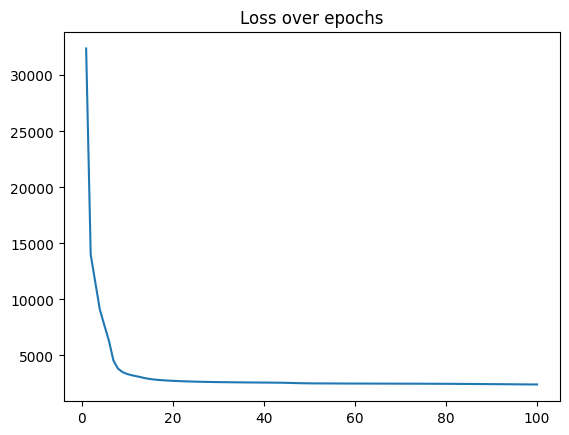

In [6]:
#@title train a one layer CSA_AE model
model = CSA_AE(1, (28*28)).to('cuda')
np.random.seed(42)
torch.manual_seed(42)
#for reproducibility
folder = 'lats_2'
nlr = 0.0002
os.makedirs(folder, exist_ok=True)
criterion1 = nn.NLLLoss()
criterion2 = nn.MSELoss(reduction = 'sum')
optimizer = optim.Adam(model.parameters(), lr=nlr)
plot_latents = False
epochs = 100
lats, labs, losses = [], [], []
for e in tqdm(range(epochs)):
    running_loss = 0
    if(e % 1 == 0):
      plot_latents = True
      lats, labs = [], []
    for images, labels in (trainloader):
        optimizer.zero_grad()
        pred, emb, recon = model(images.to('cuda'))
        output = F.log_softmax(pred, dim=1)
        nlloss = criterion1(output, labels.to('cuda'))
        mseloss = criterion2(recon, images.to('cuda'))
        loss = nlloss + mseloss
        loss.backward()
        optimizer.step()
        if(plot_latents):
          lats.append(emb.detach().cpu().squeeze().flatten(start_dim=1).numpy())
          labs.append(labels)
        running_loss += loss.item()
    losses.append(running_loss/len(trainloader))

    if(plot_latents):
      do_pca(lats, labs, folder, e)
      plot_latents = False
    #print(losses[-1])
print('\n best Loss: ', min(losses))
plt.plot(np.arange(1, epochs + 1), losses)
plt.title(f'Loss over epochs')
plt.show()
plt.close()
image_folder = f'/content/{folder}'

output_path = f'/content/{folder}/vid_out.mp4'

!ffmpeg -r 10 -i "{image_folder}/frame_%03d.png" -vcodec libx264 -pix_fmt yuv420p "{output_path}" > /dev/null 2>&1

video_path = f'/content/{folder}/vid_out.mp4'

mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

torch.save(model.state_dict(), 'csa_2.pt')
HTML(f"""
<video width=640 controls>
    <source src="{data_url}" type="video/mp4">
</video>
""")



100%|██████████| 100/100 [29:34<00:00, 17.75s/it]


 best Loss:  45220.63016807703


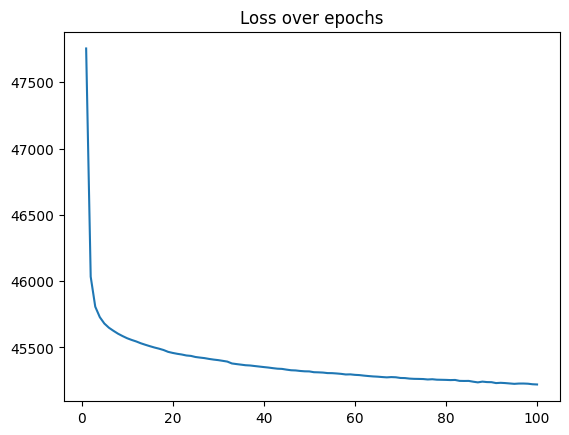

In [7]:
#@title train a one layer CSA_VAE model
model = VAE().to('cuda')
np.random.seed(42)
torch.manual_seed(42)
#for reproducibility
folder = 'lats_3'
nlr = 0.0002
os.makedirs(folder, exist_ok=True)
criterion1 = nn.NLLLoss()
criterion2 = nn.MSELoss(reduction = 'sum')
optimizer = optim.Adam(model.parameters(), lr=nlr)
plot_latents = False
epochs = 100
lats, labs, losses = [], [], []
for e in tqdm(range(epochs)):
    running_loss = 0
    if(e % 1 == 0):
      plot_latents = True
      lats, labs = [], []
    for imgs, labels in (trainloader):
        optimizer.zero_grad()
        images = imgs.flatten(start_dim=1)
        pred, emb, recon, logits = model(images.to('cuda'))
        output = F.log_softmax(pred, dim=1)
        nlloss = criterion1(output, labels.to('cuda'))
        mseloss = criterion2(recon, images.to('cuda'))
        KLD = - 0.5 * torch.sum(1+ logits[1] - logits[0].pow(2) - logits[1].exp())
        loss = nlloss + mseloss + KLD
        loss.backward()
        optimizer.step()
        if(plot_latents):
          lats.append(emb.detach().cpu().squeeze().flatten(start_dim=1).numpy())
          labs.append(labels)
        running_loss += loss.item()
    losses.append(running_loss/len(trainloader))

    if(plot_latents):
      do_pca(lats, labs, folder, e)
      plot_latents = False
    #print(losses[-1])
print('\n best Loss: ', min(losses))
plt.plot(np.arange(1, epochs + 1), losses)
plt.title(f'Loss over epochs')
plt.show()
plt.close()
image_folder = f'/content/{folder}'

output_path = f'/content/{folder}/vid_out.mp4'

!ffmpeg -r 10 -i "{image_folder}/frame_%03d.png" -vcodec libx264 -pix_fmt yuv420p "{output_path}" > /dev/null 2>&1

video_path = f'/content/{folder}/vid_out.mp4'

mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
torch.save(model.state_dict(), 'csa_1.pt')
HTML(f"""
<video width=640 controls>
    <source src="{data_url}" type="video/mp4">
</video>
""")